## Notebook used to understand the Run-Length Enconding (RLE)

From: https://en.wikipedia.org/wiki/Run-length_encoding

Run-length encoding (RLE) is a very simple form of lossless data compression in which runs of data (that is, sequences in which the same data value occurs in many consecutive data elements) are stored as a single data value and count, rather than as the original run. This is most useful on data that contains many such runs. Consider, for example, simple graphic images such as icons, line drawings, and animations. It is not useful with files that don't have many runs as it could greatly increase the file size.

A hypothetical scan line, with B representing a black pixel and W representing white, might read as follows:

```
WWWWWWWWWWWWBWWWWWWWWWWWWBBBWWWWWWWWWWWWWWWWWWWWWWWWBWWWWWWWWWWWWWW
```

With a run-length encoding (RLE) data compression algorithm applied to the above hypothetical scan line, it can be rendered as follows:

```
12W1B12W3B24W1B14W
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image as image_utils

/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
train_df = pd.read_csv("data/train.csv")

In [3]:
train_df.head()

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


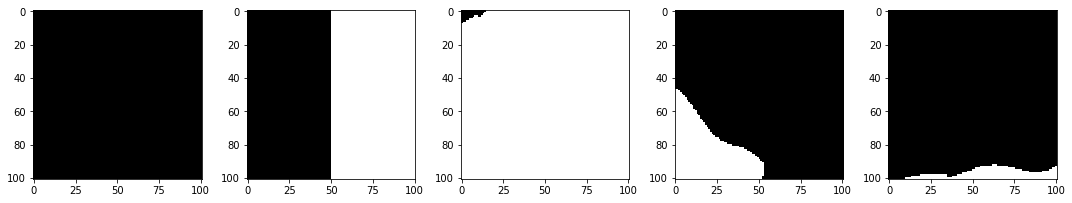

In [4]:
n_images = 5
fig, axarr = plt.subplots(1, n_images, figsize=(15, 5))
for image in range(n_images):
    axarr[image].imshow(image_utils.load_img("data/train/masks/{}.png".format(train_df.loc[image].id), grayscale=True))
fig.tight_layout()

In this case the encoding is based on pairs of `(index, length)` where the value is 1.

Then the pairs get concatenated in a flat list: `[index0, length0, index1, length1, ...]`

Black is 0 and White is 1. White is the Mask in this case White = Salt.

## Functions

Write functions that decode and encode to and from RLE

In [5]:
import math

In [6]:
def rle_decode(rle, shape):
    '''
    rle: run-length string or list of pairs of (start, length)
    shape: (height, width) of array to return 
    Returns
    -------
        np.array: 1 - mask, 0 - background
    '''
    if isinstance(rle, float) and math.isnan(rle):
        rle = []
    if isinstance(rle, str):
        rle = [int(num) for num in rle.split(' ')]
    # [0::2] means skip 2 since 0 until the end - list[start:end:skip]
    starts, lengths = [np.asarray(x, dtype=int) for x in (rle[0:][::2], rle[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 255
    img = img.reshape(1, shape[0], shape[1])
    img = img.T
    return img

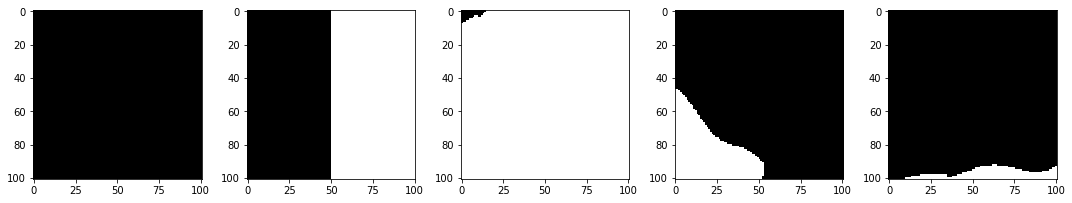

In [7]:
n_images = 5
fig, axarr = plt.subplots(1, n_images, figsize=(15, 5))
for image in range(n_images):
    axarr[image].imshow(image_utils.array_to_img(rle_decode(train_df.loc[image]['rle_mask'], (101, 101))))
fig.tight_layout()

In [8]:
def rle_encode(img):
    '''
    img: np.array: 1 - mask, 0 - background
    Returns
    -------
    run-length string of pairs of (start, length)
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle if rle else float('nan')

Compare with the whole training set masks

In [21]:
# image_utils.img_to_array(image_utils.load_img("data/train/masks/a266a2a9df.png", grayscale=True))

In [14]:
train_df['rle_calculated'] = train_df.id.map(lambda x: rle_encode(image_utils.img_to_array(image_utils.load_img("data/train/masks/{}.png".format(x), grayscale=True))))

In [15]:
train_df.head()

,id,rle_mask,rle_calculated
0,575d24d81d,NaN,NaN
1,a266a2a9df,5051 5151,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


In [16]:
pd.testing.assert_series_equal(train_df.rle_mask, train_df.rle_calculated, check_names=False)

Everything looks good, move this functions to the `utils.py`

## Interseciton over Union (IoU) Metric

The IoU

From: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

Metric = Intersection of Areas / Union of Areas

In [18]:
import random

In [12]:
def iou(y_true, y_pred):
    component1 = y_true.astype(dtype=np.bool)
    component2 = y_pred.astype(dtype=np.bool)

    overlap = component1 * component2 # Logical AND
    union = component1 + component2 # Logical OR

    iou = overlap.sum() / float(union.sum())
    return iou

In [16]:
ones = np.ones((101, 101))

In [33]:
triang_down = ones * np.tri(*ones.shape)
# triang_down

[0.8285462209587295, 0.5694539751004803, 0.106656210175473, 0.07214978923634938, 0.5148514851485149]


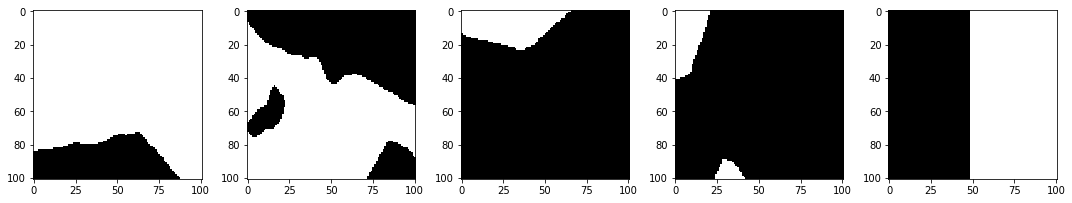

In [25]:
n_images = 5
ious = []
fig, axarr = plt.subplots(1, n_images, figsize=(15, 5))
for image in range(n_images):
    n = random.randint(1, len(train_df))
    arr = rle_decode(train_df.loc[n]['rle_mask'], (101, 101))
    axarr[image].imshow(image_utils.array_to_img(arr))
    ious.append(iou(ones, arr))
fig.tight_layout()
print(ious)

[0.339807325149187, 0.1559983043662569, 0.01825721248329534, 0.577529267226883, 0.21814368117461982]


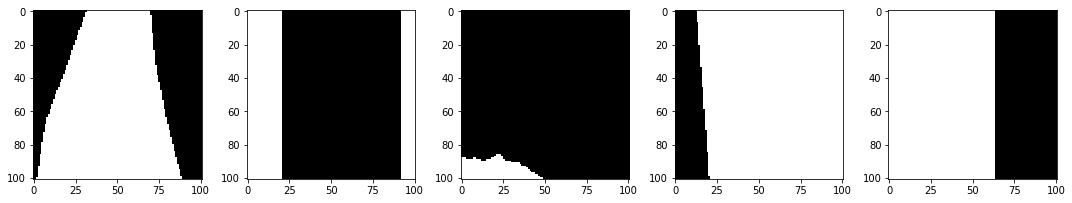

In [31]:
n_images = 5
ious = []
fig, axarr = plt.subplots(1, n_images, figsize=(15, 5))
for image in range(n_images):
    n = random.randint(1, len(train_df))
    arr = rle_decode(train_df.loc[n]['rle_mask'], (101, 101))
    axarr[image].imshow(image_utils.array_to_img(arr))
    ious.append(iou(triang_down, arr))
fig.tight_layout()
print(ious)